In [11]:
%load_ext autoreload
%matplotlib inline

In [94]:
import os,sys,glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import pickle 

import warnings

# from scipy.ndimage.filters import gaussian_filter,convolve
# interactive
# from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.signal import argrelextrema


In [30]:
## Add own library to path
workdir = os.getcwd()
repodir = workdir
projectname = 'aggregation-time-scale'
while os.path.basename(repodir) != projectname:
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
## Own functions
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

repo: /Users/bfildier/Code/analyses/aggregation-time-scale
Own modules available: ['plot2D', 'conditionalstats', 'moistdryedge']


In [31]:
# local input directory
inputdir = os.path.join(repodir,'input','irene')
figdir = os.path.join(repodir,'figures')
resultdir = os.path.join(repodir,'results')

## Load own libraries
from moistdryedge import *
from conditionalstats import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

In [107]:
simnames = 'SAM6113_RCE_SST303d1p0r1','SAM6113_RCE_SST305d1p0r1','SAM6113_RCE_SST305d2p0r1','SAM6113_RCE_SST307d1p0r1'

def getSST(simname):
    return simname.split('SST')[1][:3]
def getDtype(simname):
    return simname[-5:-4]

# for domain type
lt = {'1':'-','2':'--'}
m = {'1':'o','2':'s'}
# for SST
cmap = plt.cm.gnuplot_r
SSTmin = 302.
SSTmax = 308.
SSTs = np.arange(SSTmin,SSTmax+1,1)
SSTs_str = [str(int(SST)) for SST in SSTs]
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]
cols = dict(zip(SSTs_str,SST_col))

In [95]:
def findBeginEndIndices(vec,width=4):

    # smooth input vector
    vec_smooth = np.convolve(vec,np.linspace(1/width,1/width,width),mode='same')
    if getDtype(simname) == '1':
        n = 2
        vec_smooth2 = np.convolve(vec,np.linspace(1/(n*width),1/(n*width),(n*width)),mode='same')
    else:
        vec_smooth2 = vec_smooth
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # find local minima, if any
        locmins = argrelextrema(vec_smooth,np.less)[0]
        # find local maxima, if any
        locmaxs = list(argrelextrema(vec_smooth2,np.greater)[0])

    if len(locmins) == 0:
        i_min = np.argmax(np.logical_not(np.isnan(vec))) # first non-nan element
    else:
        i_min = locmins[0]

    if len(locmaxs) == 0:
        i_max = -np.argmax(np.logical_not(np.isnan(np.flipud(vec))))
    else:
        # only accept a window > 10
        while len(locmaxs)>0 and locmaxs[0]<i_min+10:
            del locmaxs[0]
        # pick first local max
        i_max = locmaxs[0]

    return i_min, i_max, vec_smooth

In [88]:
print("load data in dictionaries")
edgevar = 'PW'

edge = dict()
data1D = dict()
expfit = dict()
expfit_std = dict()
for simname in simnames:
    
    print(simname)
    
    # 1D data
    caseid = '_'.join(simname.split('_')[1:])
    data1D[simname] = xr.open_dataset(os.path.join(inputdir,simname+'.0',caseid+'.nc'))
    
    # edge
    file_edge = os.path.join(resultdir,simname,"edge_%s.p"%edgevar)
    edge[simname] = pickle.load(open(file_edge,"rb"))
    
    # exponential fit
    file_expfit = os.path.join(resultdir,simname,"exp_fit_params_%s.p"%edgevar)
    expfit[simname] = pickle.load(open(file_expfit,'rb'))
    file_expfit_std = os.path.join(resultdir,simname,"std_exp_fit_params_%s.p"%edgevar)
    expfit_std[simname] = pickle.load(open(file_expfit_std,'rb'))

load data in dictionaries
SAM6113_RCE_SST303d1p0r1
SAM6113_RCE_SST305d1p0r1
SAM6113_RCE_SST305d2p0r1
SAM6113_RCE_SST307d1p0r1


plot all PW-edge fracareas with exponential fit


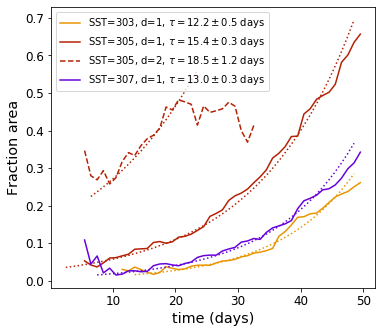

In [96]:
print("plot all PW-edge fracareas with exponential fit")

fig,ax = plt.subplots(figsize=(6,5))

for simname in simnames:
    
    # area
    area = edge[simname].fracarea_PW
    # find time limits
    i_tmin, i_tmax, area_smooth = findBeginEndIndices(area)
    s_tplot = slice(max(i_tmin-3,0),min(i_tmax+3,len(t)))
    
    # fit parameters
    t0,tau = expfit[simname]
    std_t0,std_tau = expfit_std[simname]
    
    # get SST and domain type
    SST = getSST(simname)
    dtype = getDtype(simname)
    
    # time values
    t = data1D[simname].time
    
    # label
    lab = r'SST=%s, d=%s, $\tau=%2.1f\pm%2.1f$ days'%(SST,dtype,tau,std_tau)
    
    # show fraction area and fit
    ax.plot(t,area,'k',c=cols[SST],linestyle=lt[dtype],label=lab)
    ax.plot(t[s_tplot],np.exp((t[s_tplot]-t0)/tau),c=cols[SST],linestyle=':')

# labels
ax.set_ylabel('Fraction area')
ax.set_xlabel('time (days)')

ax.legend()

plt.savefig(os.path.join(figdir,'compare',"fit_fracarea_%s.pdf"%edgevar),bbox_inches='tight')
plt.show()

plot all PW-edge log fracareas with exponential fit


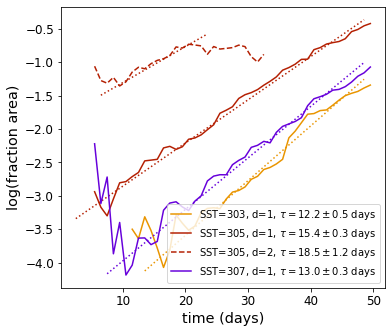

In [102]:
print("plot all PW-edge log fracareas with exponential fit")

fig,ax = plt.subplots(figsize=(6,5))

for simname in simnames:
    
    # area
    area = edge[simname].fracarea_PW
    # find time limits
    i_tmin, i_tmax, area_smooth = findBeginEndIndices(area)
    s_tplot = slice(max(i_tmin-3,0),min(i_tmax+3,len(t)))
    
    # fit parameters
    t0,tau = expfit[simname]
    std_t0,std_tau = expfit_std[simname]
    
    # get SST and domain type
    SST = getSST(simname)
    dtype = getDtype(simname)
    
    # time values
    t = data1D[simname].time
    
    # label
    lab = r'SST=%s, d=%s, $\tau=%2.1f\pm%2.1f$ days'%(SST,dtype,tau,std_tau)
    
    # show fraction area and fit
    ax.plot(t,np.log(area),'k',c=cols[SST],linestyle=lt[dtype],label=lab)
    ax.plot(t[s_tplot],(t[s_tplot]-t0)/tau,c=cols[SST],linestyle=':')

# labels
ax.set_ylabel('log(fraction area)')
ax.set_xlabel('time (days)')

ax.legend()

plt.savefig(os.path.join(figdir,'compare',"fit_log_fracarea_%s.pdf"%edgevar),bbox_inches='tight')
plt.show()

## Speed of growth, speed of the boundary, wind speed

    If we assumed that the dry patch is unique and circular at all times (which is actually not true), we would get the following relationships between the dry area $A$, dry patch radius $r$ and speed of the boundary $u_{b}$:

$$ A = \pi r^2 $$
$$ \ln A = 2 \ln r + \ln \pi$$
$$ \Rightarrow \frac{1}{\tau} \equiv \frac{1}{A}\frac{dA}{dt} = \frac{2}{r}\frac{dr}{dt} = 2\sqrt{\frac{\pi}{A}}u_b$$

    If the boundary propagation speed is proportional to the surface wind speed we would get:

$$ \frac{1}{\tau} \propto \frac{u_s}{\sqrt{A}} $$

    If the time scale is constant, this should hold over time:

$$ A(t) \propto \left(\tau u(t)\right)^2 $$

plot scatter plots of surface wind strength vs fraction area


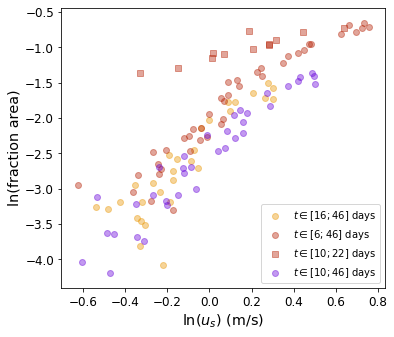

In [137]:
print("plot scatter plots of surface wind strength vs fraction area")

fig,ax = plt.subplots(figsize=(6,5))

for simname in simnames:
    
    # area
    area = edge[simname].fracarea_PW
    i_tmin, i_tmax, area_smooth = findBeginEndIndices(area)
    s_t = slice(i_tmin,i_tmax)
    # surface winds
    usfc = edge[simname].UHSFC_mean
    
    # fit parameters
    t0,tau = expfit[simname]

    # get SST and domain type
    SST = getSST(simname)
    dtype = getDtype(simname)
    
    # label
    lab = r'$t\in [%2.0f;%2.0f]$ days'%(t[i_tmin],t[i_tmax])
    
    # show fraction area and fit
#     x = np.log((usfc[s_t]*tau)**2)
#     x = np.log((usfc[s_t]*tau))
    x = np.log((usfc[s_t]))
    y = np.log(area[s_t])
    ax.scatter(x,y,color=cols[SST],marker=m[dtype],alpha=0.4,label=lab)

# labels
ax.set_ylabel('ln(fraction area)')
ax.set_xlabel(r'$\ln(u_s)$ (m/s)')

ax.legend()

plt.savefig(os.path.join(figdir,'compare',"log_fracarea_vs_log_usfc_at_%s_edge.pdf"%edgevar),bbox_inches='tight')
plt.show()

plot scatter plots of surface wind strength vs fraction area


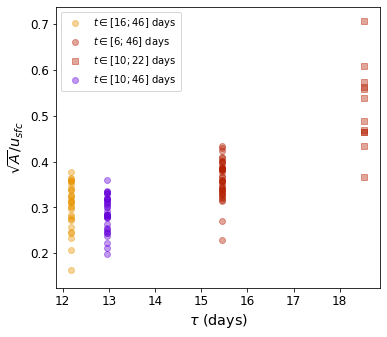

In [136]:
print("plot scatter plots of surface wind strength vs fraction area")

fig,ax = plt.subplots(figsize=(6,5))

for simname in simnames:
    
    # area
    area = edge[simname].fracarea_PW
    i_tmin, i_tmax, area_smooth = findBeginEndIndices(area)
    s_t = slice(i_tmin,i_tmax)
    # surface winds
    usfc = edge[simname].UHSFC_mean
    
    # fit parameters
    t0,tau = expfit[simname]
    
    # get SST and domain type
    SST = getSST(simname)
    dtype = getDtype(simname)
    
    # label
    lab = r'$t\in [%2.0f;%2.0f]$ days'%(t[i_tmin],t[i_tmax])
    
    # show fraction area and fit
    x = [tau]*(area[s_t].size)
    y = np.sqrt(area)[s_t]/usfc[s_t]

    ax.scatter(x,y,color=cols[SST],marker=m[dtype],alpha=0.4,label=lab)

# labels
ax.set_ylabel(r'$\sqrt{A}/u_{sfc}$')
ax.set_xlabel(r'$\tau$ (days)')

ax.legend()

plt.savefig(os.path.join(figdir,'compare',"A_div_ub2_vs_tau2_edge_%s.pdf"%edgevar),bbox_inches='tight')
plt.show()